# California Housing

Task : predict median house values in Californian districts, given a number of features from these districts.

# Setup

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Quick look to the data structure

In [2]:
#load the data
housing = pd.read_csv('datasets/housing/housing.csv')

In [3]:
#Quick look to the data
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


**Comments**:
- There are 10 attributs: longitude, latitude, housing_median_age, etc. <br>
- The names of attributes are self explanatory.

In [4]:
#Concise summary of housing DataFrame
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


**Comments**:
- total_bedrooms attribut has 207 missing values (207 district are missing). <br>
- All attributes are numerical (float64 type), except the ocean_proximity atribute which is an object.  

In [5]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

**Comments**: <br>
ocean_proximity is categorical attribute withe 4 categories.

In [6]:
#Descriptive statistics summary
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


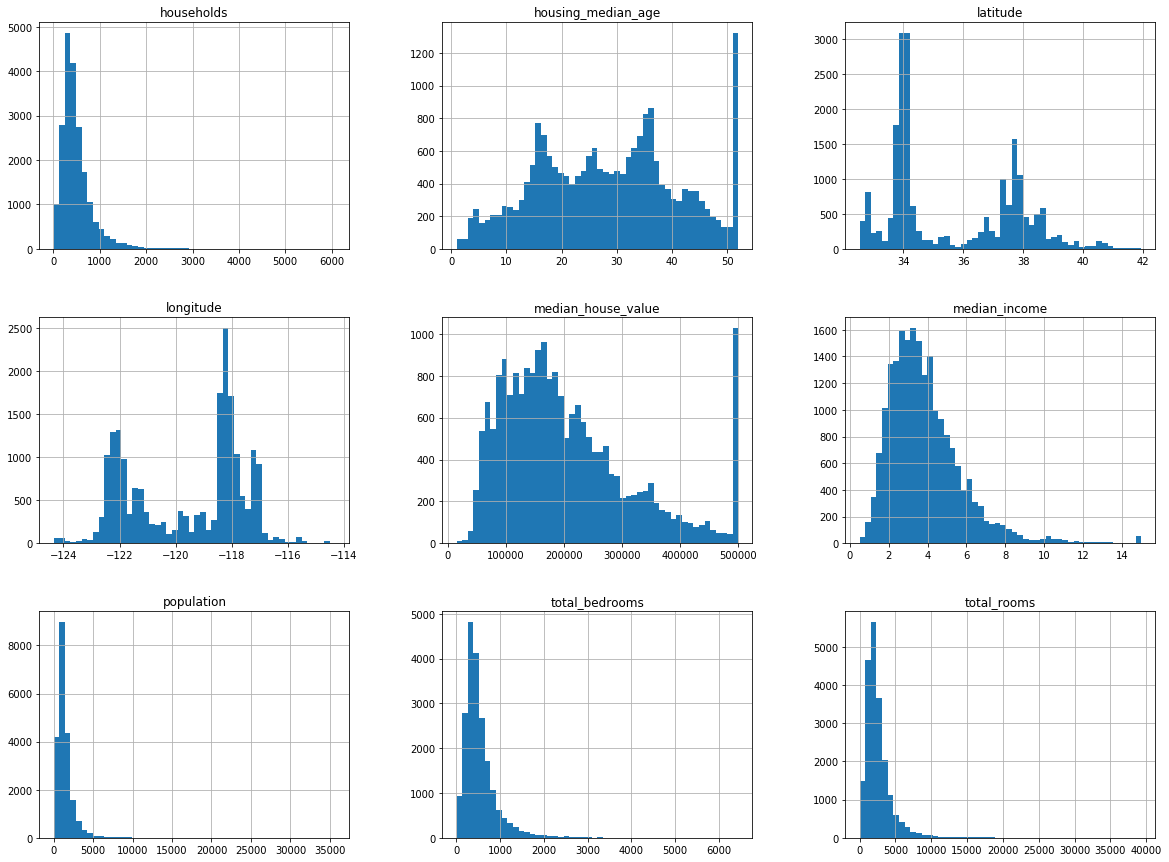

In [7]:
#Representation of the distribution of data (histogram)
housing.hist(bins=50, figsize=(20,15))
plt.show()

**Comments**: <br>
- The median income does not lokk like it is expressed in USD
- The mediane house age and the mediane house value were capped. ML alogorith may learn that price (mediane house value) never go beyond that limite ( = 500001 USD)
   - collect propoer labels for the district whose labels were capped.
   - romove those districts from the training set and from the test set 
- The attributes have very different scales
- Many histograms are tail-heavy : they extend much farther to the right of the median that to the left

# Create Train and Test sets

In [8]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

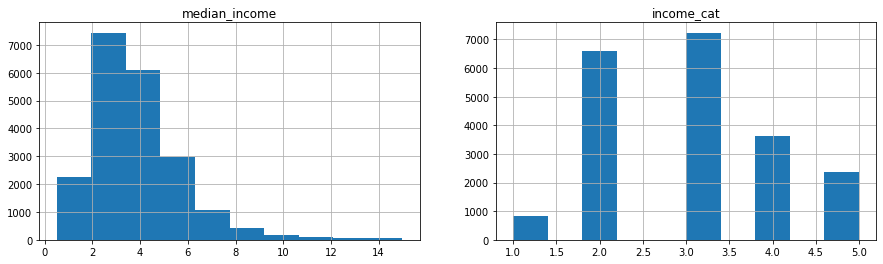

In [9]:
# add the income_cat attribute
housing['income_cat'] = pd.cut(housing['median_income'], 
                               bins=[0., 1.5, 3.0, 4.5, 6., 
                               np.inf], labels=[1, 2, 3, 4, 5])
fig, axes = plt.subplots(1, 2)
housing['median_income'].hist(ax=axes[0], figsize=(15,4))
housing['income_cat'].hist(ax=axes[1])
axes[0].set_title('median_income')
axes[1].set_title('income_cat')
plt.show()


In [10]:
#Random sampling methode
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [11]:
#Stratified sampling methode
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index] 

**Comments**: <br> 
`StratifiedShuffleSplit()` provides train/test indices to split data in train/test sets. The folds are made by preserving the percentage of samples for each class ([scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html)).

In [12]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)
compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()

compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

compare_props.head(5)

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


In [13]:
#Remouve the income_cat inttribute 
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)
#strat_train_set_new = strat_train_set.drop("income_cat", axis = 1)
#strat_test_set_new = strat_test_set.drop("income_cat", axis = 1)

In [14]:
housing = strat_train_set.copy()

# Data Exploratory & Visualisation 

## Visualizing Geographical Data

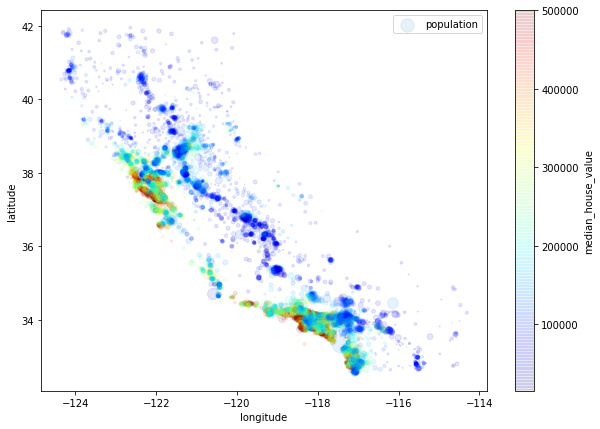

In [15]:
ax = housing.plot(kind='scatter', x= 'longitude', y='latitude', alpha=0.1,
            s = housing['population']/100, label='population', c='median_house_value', 
            cmap=plt.get_cmap('jet'), colorbar=True, figsize=(10,7),sharex=False)
plt.legend()
plt.show()

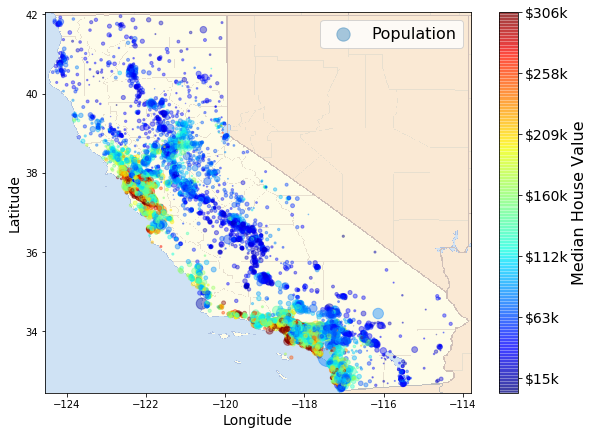

In [16]:
california_img = plt.imread('images/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

**Comments**: <br>
The housing prices are very mach related to the location (close to the ocean) and to the population density. Therefore, the ocean_proximity attribut may be usful. Nonetheless, we note that in Northern California, the housing prices in coastal district are not too high. So the ocean proximity rules is not so simple.

## Looking for Correlations

In [17]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

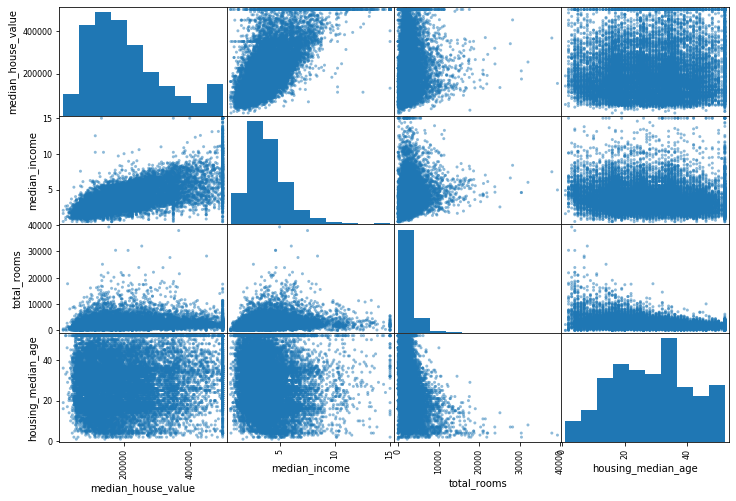

In [18]:
select_attributes = ['median_house_value', 'median_income','total_rooms','housing_median_age']
pd.plotting.scatter_matrix(housing[select_attributes], figsize=(12,8))
plt.show()

**Comments**: <br>
The most promosing attribute to predict the mediane house vlaue is the median income.

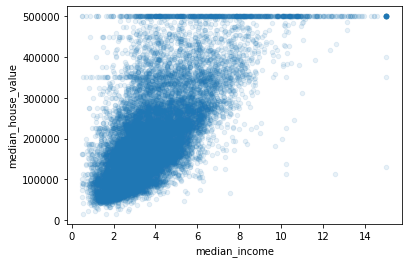

In [19]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

**Comments**: <br>
This plot reveal a few things : 
- the correlation is inded very strong 
- horizontal lines at : 500,000 USD (price cap), 450,000 USD, 350,000 USD, 280,000 USD and a few more below that. 

## Attributes combinations

In [20]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

<b>Comments.</b> <br>
The attribute bedrooms_per_room is much more correlated with the mediane house value than the total number of rooms or bedrooms.
The attribute rooms_per_household is mor informative than the total number of rooms in an district.  

# Prepare the data for ML algorithms

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn. compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

In [22]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()
housing_num = housing.drop('ocean_proximity', axis=1)
housing_cat = housing[['ocean_proximity']].copy()

In [23]:
# column index
total_rooms_ix, households_ix, population_ix, total_bedrooms_ix= 3, 6, 5, 4
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:,total_rooms_ix] / X[:,households_ix] 
        population_per_household = X[:,population_ix] / X[:,households_ix] 
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,total_bedrooms_ix] / X[:, total_rooms_ix] 
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [24]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

In [25]:
housing_prepared = full_pipeline.fit_transform(housing)

# Select and train a model

In [1]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score

In [2]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [28]:
#Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
lin_train_pred = lin_reg.predict(housing_prepared)
lin_mse = mse(housing_labels, lin_train_pred)
lin_rmse = np.sqrt(lin_mse)
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, 
                             scoring='neg_mean_squared_error', cv=10)
lin_scores = np.sqrt(-lin_scores)

print("LinearRegression")
print("rmse:", lin_rmse)
display_scores(lin_scores)

LinearRegression
rmse: 68628.19819848923
Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.6740017983457


In [36]:
#ElasticNet Regression
enet_reg = ElasticNet(alpha=0.05, l1_ratio=0.2)
enet_reg.fit(housing_prepared, housing_labels)
enet_train_pred = enet_reg.predict(housing_prepared)
enet_mse = mse(housing_labels, enet_train_pred)
enet_rmse = np.sqrt(enet_mse)
enet_scores = cross_val_score(enet_reg, housing_prepared, housing_labels, 
                             scoring='neg_mean_squared_error', cv=10)
enet_scores = np.sqrt(-enet_scores)

print("LinearRegression")
print("rmse:", enet_rmse)
display_scores(enet_scores)

LinearRegression
rmse: 69263.25902165365
Scores: [67256.89003661 67666.97284501 69912.21133794 73080.44037153
 68748.9338009  72061.37301467 65801.12600307 68927.32928618
 72438.84552034 68826.54549453]
Mean: 69472.06677107868
Standard deviation: 2271.5172541251554


In [30]:
#Decision Tree Regressor
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)
tree_train_pred = tree_reg.predict(housing_prepared)
tree_mse = mse(housing_labels, tree_train_pred)
tree_rmse = np.sqrt(tree_mse)
tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                             scoring='neg_mean_squared_error', cv=10)
tree_scores = np.sqrt(-tree_scores)
print("\nDecisionTreeRegressor")
print("rmse:", tree_rmse)
display_scores(tree_scores)


DecisionTreeRegressor
rmse: 0.0
Scores: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
Mean: 71407.68766037929
Standard deviation: 2439.4345041191004


In [37]:
#Random Forest Regressor
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)
forest_train_pred = forest_reg.predict(housing_prepared)
forest_mse = mse(housing_labels, forest_train_pred)
forest_rmse = np.sqrt(forest_mse)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, 
                             scoring='neg_mean_squared_error', cv=10)
forest_scores = np.sqrt(-forest_scores)
print("\nRandomForestRegressor")
print("rmse:", forest_rmse)
display_scores(forest_scores)


RandomForestRegressor
rmse: 18603.515021376355
Scores: [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
Mean: 50182.303100336096
Standard deviation: 2097.0810550985693


In [ ]:
#SVM Regressor
svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
svm_predict_train = svm_reg.predict(housing_prepared)
svm_mse = mse(housing_labels, svm_predict_train)
svm_rmse = np.sqrt(svm_mse)
svm_scores = cross_val_score(svm_reg, housing_prepared, housing_labels,  scoring='neg_mean_squared_error', cv=10  )
print("\nSVM Regressor")
print("rmse:", svm_rmse)
display_scores(svm_scores)


## Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

In [ ]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_rmse = np.sqrt(mse(y_test, final_predictions))
print("final_rmse:", final_rmse)

**Comments** 
Most district median_housing_values range between 120,000 USD and 265,000 USD. So, with an RMSE = 47730 USD, our result is not so good ! 

In [ ]:
#Get the relative importance of each attribute
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

In [ ]:
combined_attribut = ['rooms_per_household', 'population_per_household', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_oho_attributes = list(cat_encoder.categories_[0])
attributes = num_attribs + combined_attribut + cat_oho_attributes
sorted(zip(feature_importances, attributes), reverse=True)

In [ ]:
def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]
        

**Comments**: <br> 
`argpartition(array, k)` : The k-th element will be in its final sorted position and all smaller elements will be moved before it and all larger elements behind it. ([NumPy documentation](https://numpy.org/doc/1.18/reference/generated/numpy.argpartition.html)).


In [ ]:
grid_search.best_estimator_

In [ ]:
k=7
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [ ]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)


In [ ]:
best_forest_model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=k, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('forest_reg', best_forest_model)
])

In [ ]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

In [ ]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = prepare_select_and_predict_pipeline.predict(X_test)
final_rmse = np.sqrt(mse(y_test, final_predictions))
print("final_rmse:", final_rmse)